In [16]:
%matplotlib ipympl
import os
import time
import pandas
import traceback
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from onix.helpers import present_float
from onix.models.schiff import inverse_fa_limit, axion_frequency_to_mass, axion_mass_to_frequency
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr
from allantools import adev, mdev
from astropy.timeseries import LombScargle
from scipy.stats import norm


In [17]:
def phase_fit(phi, A, C, phi_0):
    return A * np.cos(phi - phi_0) + C

def get_phase_fitter(phases, heights, height_errs):
    fitter = Fitter(phase_fit)
    fitter.set_data(phases, heights, height_errs)
    fitter.set_bounds("A", 0, np.inf)

    # setting this bound makes weird fits for certain phi_0's because they want to fit to a value outside the bound
    # fitter.set_bounds("phi_0", 0, 2*np.pi)
    fitter.fit()
    return fitter

In [18]:
def gaussian_fit(f, f0, a, sigma, c):
    return np.exp(-(f-f0)**2 / sigma**2) * a + c



def double_gaussian_fit(f, f1, f2, a1, a2, sigma, c):
    return gaussian_fit(f, f1, a1, sigma, 0) + gaussian_fit(f, f2, a2, sigma, 0) + c

def get_double_gaussian_fitter(fs, pops):
    fitter = Fitter(double_gaussian_fit)
    fitter.set_data(fs, pops)
    fitter.set_bounds("a1", 0, np.inf)
    fitter.set_bounds("a2", 0, np.inf)
    fitter.set_bounds("sigma", 0, np.inf)
    fitter.set_p0(
        {
            "f1": -np.average(np.abs(fs)),
            "f2": np.average(np.abs(fs)),
            "a1": np.max(pops) - np.min(pops),
            "a2": np.max(pops) - np.min(pops),
            "sigma": np.average(np.abs(fs)) / 4,
            "c": np.min(pops),
        }
    )
    fitter.fit()
    return fitter


In [19]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

In [20]:
def get_normalized_transmission(data_number):
    data, header = get_experiment_data(data_number)
    if "fid" in header["params"]["detect"] and header["params"]["detect"]["fid"]["use"]:
        sample_rate = header["params"]["digitizer"]["sample_rate"]
        fid_params = header["params"]["detect"]["fid"]
        start_time = (fid_params["pump_time"] + fid_params["wait_time"]).to("s").magnitude + 7e-6
        fft_end_time = start_time + fft_end_time_s
        times = np.arange(len(data["transmissions_avg"][0])) / sample_rate
        mask = (times > start_time) & (times < fft_end_time)
        time_resolution = times[1] - times[0]
        fs = np.fft.rfftfreq(len(data["transmissions_avg"][0][mask]), d=time_resolution)
        duration = times[mask][-1] - times[mask][0]
        N = duration / time_resolution
        freqs_to_probe = []
        center_detuning = (header["params"]["detect"]["fid"]["probe_detuning"] - header["params"]["detect"]["detunings"][0]).to("Hz").magnitude
        if header["params"]["field_plate"]["use"]:
            electric_field_shift = header["params"]["field_plate"]["stark_shift"].to("Hz").magnitude
            freqs_to_probe.append(center_detuning - electric_field_shift)
            freqs_to_probe.append(center_detuning + electric_field_shift)
        else:
            freqs_to_probe.append(center_detuning)
        freqs_to_probe = np.abs(freqs_to_probe)
        detunings_MHz = np.array(freqs_to_probe) * 1e-6
        indices_to_probe = []
        for freq in freqs_to_probe:
            closest_index = np.argmin(np.abs(fs - freq))
            indices_to_probe.append(closest_index)
        normalized_avg = [[] for kk in freqs_to_probe]
        for kk, d in enumerate(data["transmissions_avg"]):
            if kk >= fft_first_N:
                continue
            ys = np.fft.rfft(d[mask]) * 2 / N
            for ll, closest_index in enumerate(indices_to_probe):
                normalized_avg[ll].append(np.sum(np.abs(ys[closest_index - fft_average_scan: closest_index+fft_average_scan+1])))
        normalized_avg_avg = np.abs(np.average(normalized_avg, axis=1))
        # normalized_avg_std = np.std(np.abs(np.array(normalized_avg) - normalized_avg_avg), axis=1)
        # normalized_avg_std /= len(normalized_avg[0])
        normalized_avg = {"3": -unumpy.uarray(normalized_avg_avg, np.zeros(len(normalized_avg_avg))), "6": ufloat(0,0)}

    else:
        detunings_MHz = header["detunings"].to("MHz").magnitude
        if "1" in header["params"]["detect"]["cycles"] and "2" in header["params"]["detect"]["cycles"] and header["params"]["detect"]["cycles"]["1"] != header["params"]["detect"]["cycles"]["2"]:
            del header["params"]["detect"]["cycles"]["1"]
        transmissions_avg, transmissions_err = group_and_average_data(data["transmissions_avg"], header["params"]["detect"]["cycles"], return_err=True)
        monitors_avg, monitors_err = group_and_average_data(data["monitors_avg"], header["params"]["detect"]["cycles"], return_err=True)
        normalized_avg = {}
        for kk in transmissions_avg:
            if transmissions_avg[kk].ndim >= 1:
                normalized_avg[kk] = unumpy.uarray(
                    transmissions_avg[kk] / monitors_avg[kk],
                    np.sqrt(
                        (transmissions_err[kk] / monitors_avg[kk]) ** 2
                        + (transmissions_avg[kk] * monitors_err[kk] / monitors_avg[kk]) ** 2
                    )
                )
            else:
                normalized_avg[kk] = ufloat(
                    transmissions_avg[kk] / monitors_avg[kk],
                    np.sqrt(
                        (transmissions_err[kk] / monitors_avg[kk]) ** 2
                        + (transmissions_avg[kk] * monitors_err[kk] / monitors_avg[kk]) ** 2
                    )
                )
    return detunings_MHz, normalized_avg, header

In [21]:
def get_experiment_result(data_number):
    detunings, data, header = get_normalized_transmission(data_number)
    total_pop_1 = 1
    if "1" in data:
        pop_other_state_1 = data["1"] - data["2"]
    else:
        pop_other_state_1 = - data["2"]
    return (header, detunings, pop_other_state_1, total_pop_1)

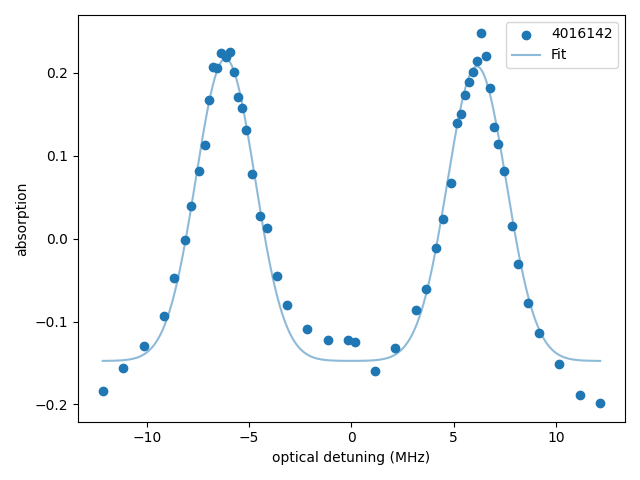

In [7]:
#for kk in [3055859, 3055866, 4040940, 4041059, 3095958]:
for kk in [4016142]:
    header, detunings, pop_other_state, total_pop = get_experiment_result(kk)
    fig, ax = plt.subplots()
    vals = unumpy.nominal_values(pop_other_state)
    fitter = get_double_gaussian_fitter(detunings, vals)
    ax.scatter(detunings, vals, label = kk);
    f_axis = np.linspace(np.min(detunings), np.max(detunings), 1000)
    ax.plot(f_axis, fitter.fitted_value(f_axis), label = "Fit", alpha = 0.5)


ax.set_xlabel("optical detuning (MHz)")
ax.set_ylabel("absorption")
ax.legend()
plt.tight_layout()
plt.show()

In [8]:
def get_results(data_identification):
    data_list = data_identification_to_list(data_identification)
    headers = []
    results = []
    for data_number in data_list:
        header, detunings, pop_other_state, total_pop = get_experiment_result(data_number)
        if len(detunings) > 2:
            fitter = get_double_gaussian_fitter(detunings, unumpy.nominal_values(pop_other_state))
            headers.append(header)
            results.append(
                unumpy.uarray(
                    [fitter.results["a1"], fitter.results["a2"]],
                    [fitter.errors["a1"], fitter.errors["a2"]],
                )
            )
        else:
            headers.append(header)
            results.append(pop_other_state)
    return headers, np.array(results)

In [4]:
def averaging_ys(xs, ys):
    xs_unique = np.unique(xs)
    ys_to_avg = [[] for _ in range(len(xs_unique))]
    for x, y in zip(xs, ys):
        ys_to_avg[np.argwhere(xs_unique == x)[0][0]].append(y)
    ys_avg = []
    ys_std = []
    for y_list in ys_to_avg:
        ys_avg.append(np.average(y_list))
        ys_std.append(np.std(y_list))
    ys_avg = np.array(ys_avg)
    ys_std = np.array(ys_std)
    
    return xs_unique, ys_avg, ys_std

## long term phase scan

In [5]:
import onix.models.hyperfine as hyperfine
magnetic_field = 223e-4
ground = hyperfine.states["7F0"]
ground._Hamiltonian = ground.H_total(magnetic_field)
e_g, s_g = ground.energies_and_eigenstates()

a_I_dot_n = (s_g[0].dag() * ground._I_x * s_g[0]).tr()
abar_I_dot_n = (s_g[1].dag() * ground._I_x * s_g[1]).tr()
b_I_dot_n = (s_g[2].dag() * ground._I_x * s_g[2]).tr()
bbar_I_dot_n = (s_g[3].dag() * ground._I_x * s_g[3]).tr()
I_a = (abar_I_dot_n - a_I_dot_n) / 2
I_b = (bbar_I_dot_n - b_I_dot_n) / 2

def combine_polarization_data(results):
    def check_equal_and_append(check_from, check_name, append_to):
        check_col = check_from[:, col_indices[check_name]]
        count = np.unique(check_col)
        if len(count) > 1:
            raise Exception(f"{check_name} is not the same.")
        append_to.append(check_col[0])

    results_array = pandas.DataFrame.from_dict(results).to_numpy()
    keys = list(results.keys())
    indices = list(range(len(keys)))
    col_indices = dict(zip(keys, indices))
    data = {
        "f+": [],
        "f-": [],
        "start_time": [],
        "end_time": [],
        "temp": [],
        "phi0+": [],
        "phi0-": [],
    }
    group_size = 2
    for kk in range(len(results_array) // group_size):
        sub_data = results_array[kk * group_size: kk * group_size + group_size]
        data_indices = []
        for name in results.keys():
            if name not in ["start_time", "end_time", "D", "freq_center", "temp", "phi0"]:
                if name not in data:
                    data[name] = []
                check_equal_and_append(sub_data, name, data[name])
        for ll, datapoint in enumerate(sub_data):
            if ll == 0:
                start_time = datapoint[col_indices["start_time"]]
            if ll == len(sub_data) - 1:
                end_time = datapoint[col_indices["end_time"]]
            if datapoint[col_indices["D"]]:
                f_p = datapoint[col_indices["freq_center"]]
                phi0_p = datapoint[col_indices["phi0"]]
            else:
                f_m = datapoint[col_indices["freq_center"]]
                phi0_m = datapoint[col_indices["phi0"]]


        data["f+"].append(f_p)
        data["f-"].append(f_m)
        data["phi0+"].append(phi0_p)
        data["phi0-"].append(phi0_m)
        data["start_time"].append(start_time)
        data["end_time"].append(end_time)
        data["temp"].append(np.nanmean(sub_data[:, col_indices["temp"]]))

    data["f+"] = np.array(data["f+"])
    data["f-"] = np.array(data["f-"])
    data["phi0+"] = np.array(data["phi0+"])
    data["phi0-"] = np.array(data["phi0-"])
    data["Z"] = (data["f+"] + data["f-"]) / 4
    data["W_T"] = []
    for kk in range(len(data["f+"])):
        if data["state"][kk] == "a":
            I = I_a
        else:
            I = I_b
        data["W_T"].append((data["f+"][kk] - data["f-"][kk]) / 4 / I)

    keys = list(data.keys())
    indices = list(range(len(keys)))
    col_indices = dict(zip(keys, indices))
    data = pandas.DataFrame.from_dict(data).to_numpy()
    return data, col_indices

In [6]:
analysis_dnum = 613 # folder where its saved
ignore_data_numbers = []

In [7]:
import uncertainties.core

class CallableStdDev(float):
    '''
    Class for standard deviation results, which used to be
    callable. Provided for compatibility with old code. Issues an
    obsolescence warning upon call.
    '''

    # This class is a float. It must be set to the standard deviation
    # upon construction.

    def __call__ (self):
        deprecation('the std_dev attribute should not be called'
                    ' anymore: use .std_dev instead of .std_dev().')
        return self

uncertainties.core.CallableStdDev = CallableStdDev

In [10]:
data_range = (4625431 , 4625431 + 3)
max = 4654432

points_per_scan = data_range[1] - data_range[0]
first = data_range[0]
last = max
first_unprocessed = first
all_old_data = False
all_new_data = True

loaded_data = None
path_to_save = get_analysis_file_path(analysis_dnum, f"{first}_{last}_processed.npz")
dir = os.path.dirname(path_to_save)
for file in os.listdir(dir):
    file_splitted = file.split("_")
    start_str = file_splitted[0]
    stop_str = file_splitted[1]
    start = int(start_str)
    stop = int(stop_str)
    if start == data_range[0]:
        all_new_data = False
        if stop == max:
            all_old_data = True
        first_unprocessed = stop + 1
        old_data_path = os.path.join(dir, file)
        loaded_data = np.load(old_data_path, allow_pickle = True)
        print("Existing data loaded")
        break
    
current = first_unprocessed + points_per_scan
offset = 0
all_results = {
    "lf_center_freq": [],
    "freq_center": [],
    "state": [],
    "E": [],
    "D": [],
    "field_plate_amplitude": [],
    "electric_field_shift_MHz": [],
    "pulse_time_ms": [],
    "wait_time_ms": [],
    "ramp_time_ms": [],
    "start_time": [],
    "end_time": [],
    "temp": [],
    "rf_amplitude": [],
    "rf_duration_ms": [],
    "phi0": [],
}

if all_old_data is False:
    while current + offset <= max:
        data_range_now = (first_unprocessed + offset, first_unprocessed + points_per_scan + offset)
        if data_range_now[0] in ignore_data_numbers:
            offset += 1
            continue
        data_list = data_identification_to_list(data_range_now)
        try:
            headers, results = get_results(data_range_now)
        except Exception:
            offset += len(list(data_list))
            continue
    
        for header in headers:
            if "temp" not in header or header["temp"] is None:
                header["temp"] = np.nan
    
        index = []
        for header in headers:
            sequence = header["params"]["sequence"]["sequence"]
            for name, repeat in sequence:
                if name.startswith("lf") and not name.endswith("piov2"):
                    index.append(int(name.split("_")[-1]))
                    break
                    
        center_freq = headers[0]["params"]["lf"]["center_frequency"].to("Hz").magnitude
        pulse_time_ms = headers[0]["params"]["lf"]["piov2_time"].to("ms").magnitude
        wait_time_ms = headers[0]["params"]["lf"]["wait_time"].to("ms").magnitude
        total_time_ms = pulse_time_ms + wait_time_ms
        detuning = headers[0]["params"]["lf"]["detuning"].to("Hz").magnitude
        ramp_time = headers[0]["params"]["field_plate"]["ramp_time"].to("ms").magnitude
        probe_freq = center_freq + detuning
        fp_amplitude = headers[0]["params"]["field_plate"]["amplitude"]
        stark_shift = headers[0]["params"]["field_plate"]["stark_shift"].to("MHz").magnitude
        detect_detuning = headers[0]["params"]["detect"]["detunings"].to("MHz").magnitude
        E_field = fp_amplitude > 0
        phases = [header["params"]["lf"]["phase_diffs"][index[kk]] for kk, header in enumerate(headers)]
        temp = np.nanmean([header["temp"] for header in headers])
        rf_amplitude = headers[0]["params"]["rf"]["amplitude"]
        rf_duration_ms = headers[0]["params"]["rf"]["HSH"]["T_ch"].to("ms").magnitude
    
        for kk in range(2):  # positive and negative Stark components.
            ys = unumpy.nominal_values(results[:, kk])
            errs = unumpy.std_devs(results[:, kk])
            fitter = get_phase_fitter(phases, ys, None)
            phi0 = ufloat(fitter.results["phi_0"], fitter.errors["phi_0"])
            phi0 = (np.pi + phi0) % (2 * np.pi) - np.pi
            freq_center = phi0 / (2 * np.pi) / (total_time_ms * 1e-3) + probe_freq
            
            neg_DdotE = kk == 0
            E = E_field
            D = (not neg_DdotE) == E
            epoch_times = (
                headers[0]["data_info"]["save_epoch_time"],
                headers[-1]["data_info"]["save_epoch_time"],
            )
            if probe_freq > 200e3:
                state = "a"
            else:
                state = "b"
            all_results["lf_center_freq"].append(center_freq)
            all_results["freq_center"].append(freq_center)
            all_results["state"].append(state)
            all_results["E"].append(E)
            all_results["D"].append(D)
            all_results["start_time"].append(epoch_times[0])
            all_results["end_time"].append(epoch_times[1])
            all_results["pulse_time_ms"].append(pulse_time_ms)
            all_results["wait_time_ms"].append(wait_time_ms)
            all_results["field_plate_amplitude"].append(fp_amplitude)
            all_results["electric_field_shift_MHz"].append(stark_shift)
            all_results["ramp_time_ms"].append(ramp_time)
            all_results["temp"].append(temp)
            all_results["rf_amplitude"].append(rf_amplitude)
            all_results["rf_duration_ms"].append(rf_duration_ms)
            all_results["phi0"].append(phi0)
        
        offset += len(list(data_list))
    new_results, col_indices = combine_polarization_data(all_results)

    if loaded_data is None:
        results = new_results
    else:
        results = np.concatenate((loaded_data["results"], new_results), axis = 0)

    if all_new_data is False:
        try:
            os.remove(old_data_path)
        except:
            pass
    np.savez(
        path_to_save,
        results=results,
        col_indices=col_indices,
    )

else:
    results = loaded_data["results"]
    col_indices = loaded_data["col_indices"].tolist()

Existing data loaded


In [22]:
a_mask = results[:, col_indices["state"]] == "a"
b_mask = results[:, col_indices["state"]] == "b"

E_fields = np.unique(results[:, col_indices["field_plate_amplitude"]])
E_masks = [results[:, col_indices["field_plate_amplitude"]] == kk for kk in E_fields]

rf_amplitudes = np.unique(results[:, col_indices["rf_amplitude"]])
rf_amplitude_masks = [results[:, col_indices["rf_amplitude"]] == kk for kk in rf_amplitudes]

rf_durations = np.unique(results[:, col_indices["rf_duration_ms"]])
rf_duration_masks = [results[:, col_indices["rf_duration_ms"]] == kk for kk in rf_durations]

durations = np.unique(results[:, col_indices["pulse_time_ms"]])
duration_masks = [results[:, col_indices["pulse_time_ms"]] == kk for kk in durations]

E_pos_mask = results[:, col_indices["E"]] == True
E_neg_mask = results[:, col_indices["E"]] == False

start_times_a = results[a_mask, col_indices["start_time"]]
start_times_b = results[b_mask, col_indices["start_time"]]
f_p_a = results[a_mask, col_indices["f+"]]
f_m_a = results[a_mask, col_indices["f-"]]
f_p_b = results[b_mask, col_indices["f+"]]
f_m_b = results[b_mask, col_indices["f-"]]

Z_a = results[a_mask, col_indices["Z"]]
Z_b = results[b_mask, col_indices["Z"]]
W_T_a = results[a_mask, col_indices["W_T"]]
W_T_b = results[b_mask, col_indices["W_T"]]

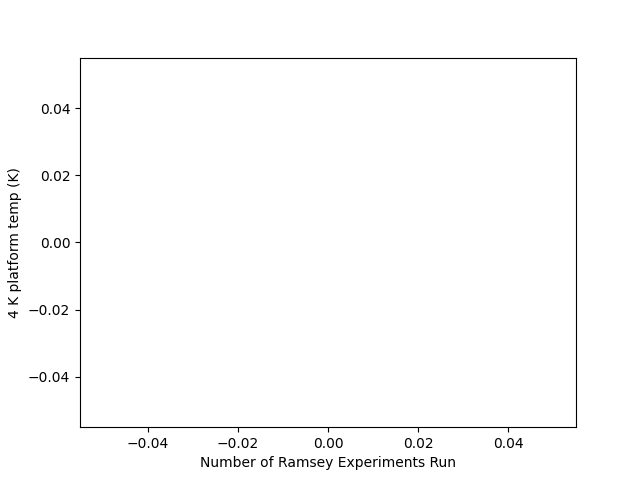

In [23]:
fig, ax = plt.subplots()

#data_numbers = first + np.arange(0, len(results[:, col_indices["W_T"]])) * 9
#temperatures = np.nan_to_num(results[:, col_indices["temp"]], nan = 0)
#ax.plot(data_numbers, temperatures)

ax.plot(results[:,col_indices["temp"]])
ax.set_xlabel("Number of Ramsey Experiments Run")
ax.set_ylabel("4 K platform temp (K)");

In [183]:
start_mask = results[:, col_indices["start_time"]] > 1722730400
cycle_times = results[:, col_indices["start_time"]][1:] - results[:, col_indices["start_time"]][:-1]
cycle_times = np.concatenate([[0], cycle_times])
cycle_time_upper_limit = 10
cycle_time_discard_mask = cycle_times > cycle_time_upper_limit
cycle_time_mask = np.ones(len(cycle_times), dtype=bool)
for kk in cycle_time_discard_mask.nonzero()[0]:
    cycle_time_mask[np.arange(kk - 5, kk + 20)] = False
sigmas = 6
f_p = unumpy.nominal_values(results[:, col_indices["f+"]])
f_p_std = np.std(f_p)
f_p_avg = np.average(f_p)
f_p_mask = (f_p < f_p_std * sigmas + f_p_avg) & (f_p > -f_p_std * sigmas + f_p_avg)
f_m = unumpy.nominal_values(results[:, col_indices["f-"]])
f_m_std = np.std(f_m)
f_m_avg = np.average(f_m)
f_m_mask = (f_m < f_m_std * sigmas + f_m_avg) & (f_m > -f_m_std * sigmas + f_m_avg)
W_T = unumpy.nominal_values(results[:, col_indices["W_T"]])
W_T_std = np.std(W_T)
W_T_avg = np.average(W_T)
W_T_mask = (W_T < W_T_std * sigmas + W_T_avg) & (W_T > -W_T_std * sigmas + W_T_avg)
mask = start_mask & cycle_time_mask & f_p_mask & f_m_mask

length_start_filtered = np.sum(start_mask)
length_unlock_filtered = np.sum(start_mask & cycle_time_mask)
length_outlier_filtered = np.sum(start_mask & cycle_time_mask & f_p_mask & f_m_mask)
print(length_start_filtered, length_start_filtered - length_unlock_filtered, length_unlock_filtered - length_outlier_filtered, length_outlier_filtered)

7250 50 2 7198


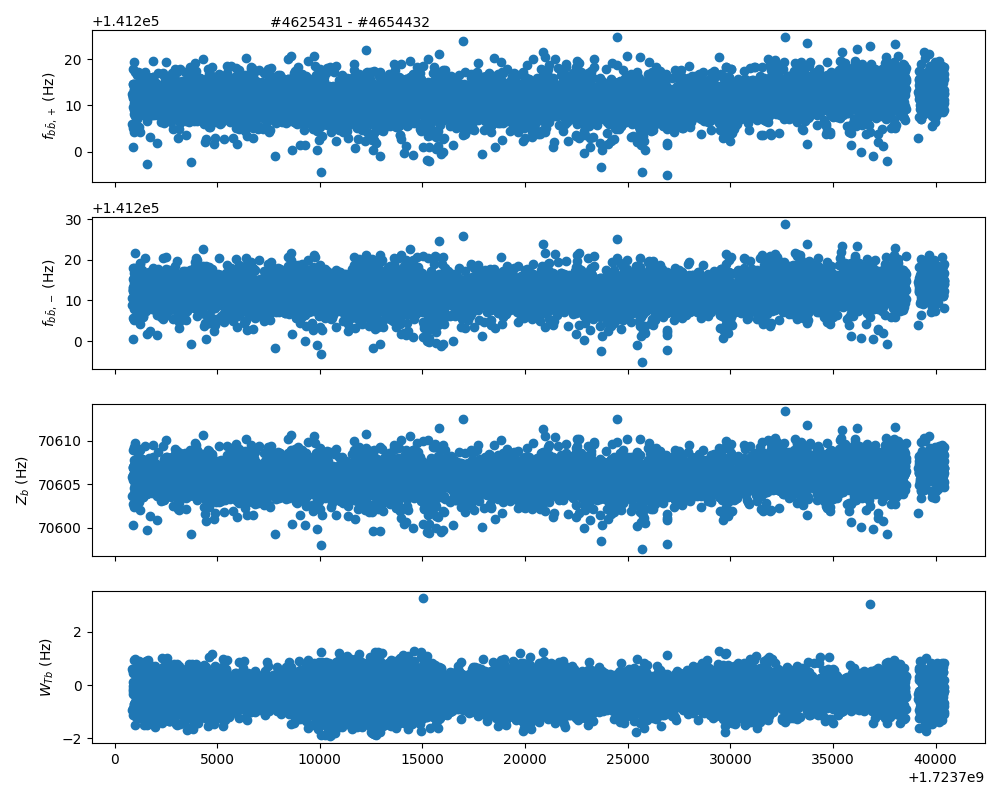

In [184]:
errorbar_args = {"fmt": "o", "ls": "none"}

mask_name = "b"
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10, 8))
axs[0].set_ylabel("$f_{" + mask_name + "\\bar{" + mask_name + "}, +}$ (Hz)")
axs[1].set_ylabel("$f_{" + mask_name + "\\bar{" + mask_name + "}, -}$ (Hz)")
axs[2].set_ylabel("$Z_" + mask_name + "$ (Hz)")
axs[3].set_ylabel("$W_{T" + mask_name + "}$ (Hz)")
for kk, d in enumerate(
    [
        results[mask, col_indices["f+"]],
        results[mask, col_indices["f-"]],
        results[mask, col_indices["Z"]],
        results[mask, col_indices["W_T"]]
    ]
):
    axs[kk].errorbar(
        results[mask, col_indices["start_time"]], unumpy.nominal_values(d), unumpy.std_devs(d) * 0,
        **errorbar_args
    )
axs[0].text(0.2, 1.02, f'#{first} - #{last}', transform = axs[0].transAxes)
plt.tight_layout()
plt.show()

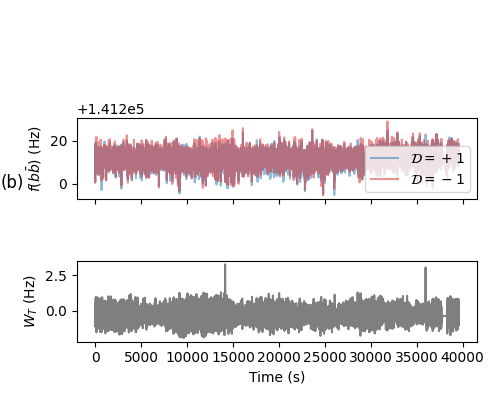

In [185]:
errorbar_args = {"fmt": "o", "ls": "none"}

mask_name = "b"
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 4))
axs[0].set_ylabel("$f(" + mask_name + "\\bar{" + mask_name + "})$ (Hz)")
axs[1].set_ylabel("$W_T$ (Hz)")
axs[1].set_xlabel("Time (s)")

times_t_series = results[mask, col_indices["start_time"]]
times_t_series -= times_t_series[0]
axs[0].plot(
    times_t_series,
    unumpy.nominal_values(results[mask, col_indices["f+"]]),
    label="$\\mathcal{D}=+1$",
    color="C0",
    alpha=0.5,
)
axs[0].plot(
    times_t_series,
    unumpy.nominal_values(results[mask, col_indices["f-"]]),
    label="$\\mathcal{D}=-1$",
    color="C3",
    alpha=0.5,
)
axs[0].text(-0.16, 1.05, "(a)", transform=ax.transAxes, fontsize=12)
axs[0].legend()
axs[1].plot(
    times_t_series,
    unumpy.nominal_values(results[mask, col_indices["W_T"]]),
    color="C7",
)
axs[1].text(-0.16, 0.43, "(b)", transform=ax.transAxes, fontsize=12)
#axs[0].text(0.2, 1.02, f'#{first} - #{last}', transform = axs[0].transAxes)
plt.tight_layout()
plt.savefig("time-series.pdf")
plt.show()

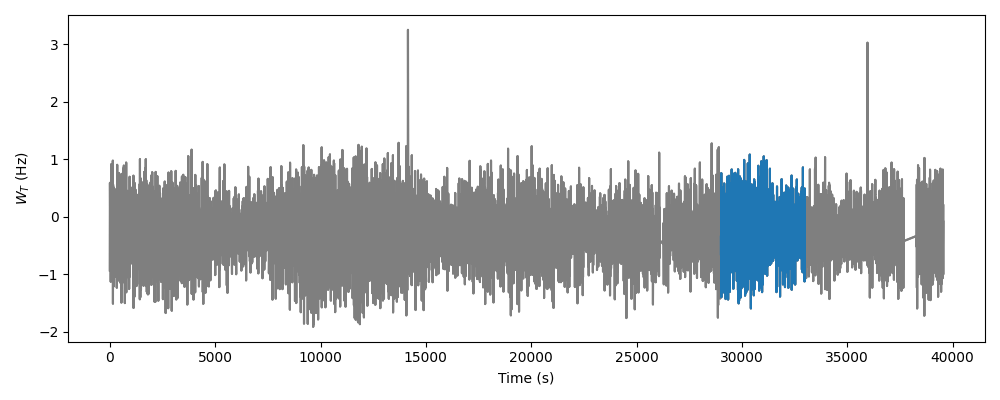

In [186]:
errorbar_args = {"fmt": "o", "ls": "none"}

mask_name = "b"
fig, ax = plt.subplots(sharex=True, figsize=(10, 4))
ax.set_ylabel("$W_T$ (Hz)")
ax.set_xlabel("Time (s)")

times_t_series = results[mask, col_indices["start_time"]]
times_t_series -= times_t_series[0]
times_t_series = np.array(times_t_series, dtype=float)
W_T_temp = unumpy.nominal_values(results[mask, col_indices["W_T"]])
ax.plot(
    times_t_series,
    W_T_temp,
    color="C7",
)
mask_cont = (times_t_series > 29000) & (times_t_series < 33000)
ax.plot(
    times_t_series,
    W_T_temp,
    color="C7",
)
ax.plot(
    times_t_series[mask_cont],
    W_T_temp[mask_cont],
    color="C0",
)
plt.tight_layout()
plt.savefig("time-series.pdf")
plt.show()

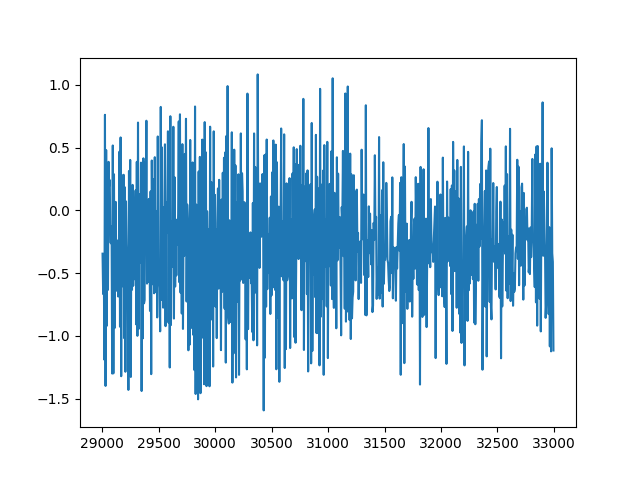

In [187]:
temp_ts = times_t_series[mask_cont]
temp_W_Ts = W_T_temp[mask_cont]

fig, ax = plt.subplots()
ax.plot(temp_ts, temp_W_Ts)
plt.show()

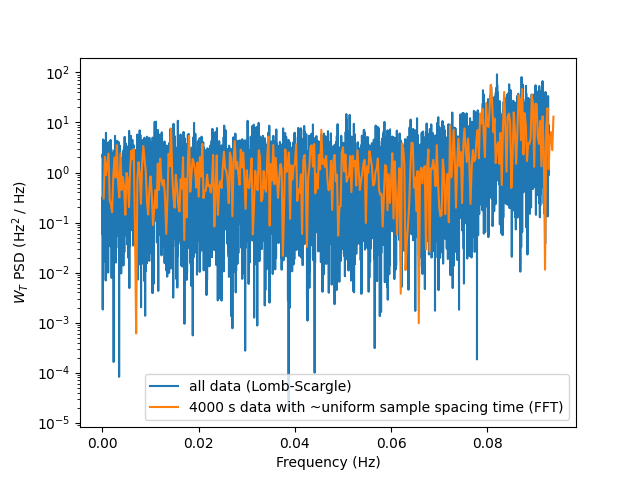

2.887800778267464
2.9969545294531437
0.06579797941372227 0.2229820984130242 0.13159595882744454 0.1571841189993019 1.194444878093938 0.2887800778267464


In [224]:
temp_fft_W_Ts = np.fft.rfft(temp_W_Ts)[1:]
sample_time = (np.max(temp_ts) - np.min(temp_ts)) / (len(temp_ts) - 1)
temp_psd_W_Ts = np.abs(temp_fft_W_Ts)**2 * 2 * sample_time / len(temp_ts)
temp_fs = np.fft.rfftfreq(len(temp_W_Ts), sample_time)[1:]

W_T = unumpy.nominal_values(results[:, col_indices["W_T"]])[mask]
times = results[:, col_indices["start_time"]].astype(float)[mask]
ls = LombScargle(times, W_T, normalization="psd")

min_freq = 0.5 / duration  # 4 times longer than the oscillation
max_freq = 0.5 / cycle_time_avg
fs, f_W_T_psd = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)


fig, ax = plt.subplots()
ax.plot(fs, f_W_T_psd * 2 * sample_time, label="all data (Lomb-Scargle)")
ax.plot(temp_fs, temp_psd_W_Ts, label="4000 s data with ~uniform sample spacing time (FFT)")
ax.set_yscale("log")
ax.set_ylabel("$W_T$ PSD (Hz$^2$ / Hz)")
ax.set_xlabel("Frequency (Hz)")
ax.legend()
plt.show()
print(np.average(f_W_T_psd * 2 * sample_time))
print(np.average(temp_psd_W_Ts))

temp_first_half_sum = np.sum(f_W_T_psd[:len(f_W_T_psd) // 2]* 2 * sample_time / len(f_W_T_psd) * 0.1)
temp_second_half_sum = np.sum(f_W_T_psd[len(f_W_T_psd)//2:]* 2 * sample_time / len(f_W_T_psd) * 0.1)
temp_background_sum = temp_first_half_sum * 2
temp_pt_noise_sum = temp_second_half_sum - temp_first_half_sum
print(temp_first_half_sum, temp_second_half_sum, temp_background_sum, temp_pt_noise_sum, temp_pt_noise_sum / temp_background_sum, temp_pt_noise_sum + temp_background_sum)

In [219]:
duration = np.max(results[:, col_indices["start_time"]][mask]) - np.min(results[:, col_indices["start_time"]][mask])
Ncycle = len(results[mask])
cycle_time_avg = np.sum(cycle_times[mask]) / Ncycle  # the first cycle is set to 0 s.
cycle_frequency_avg = 1 / cycle_time_avg

W_tb_unc = np.average(np.std(unumpy.nominal_values(W_T_b[mask]))) / np.sqrt(len(W_T_b[mask]))

print(f'#{first} - #{last}')
print(f"Time: {duration:.1f} s, N_cycle = {Ncycle}")
print(f"Cycle time (laser unlock time not included): {cycle_time_avg:.2f} s, cycle frequency {cycle_frequency_avg:.2f} Hz")
print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b)), np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))), "Hz")
print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b)), np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))), "Hz")
print("W_T =", present_float(np.average(unumpy.nominal_values(W_T_b)), W_tb_unc, 2), "Hz")
print(f"W_T_unc sensitivity = {W_tb_unc / np.sqrt(3600 / duration):.3f} Hz sqrt(hr)")
print(f"W_T_unc per cycle = {W_tb_unc*np.sqrt(Ncycle):.2f} Hz")


#4625431 - #4654432
Time: 39564.4 s, N_cycle = 7198
Cycle time (laser unlock time not included): 5.39 s, cycle frequency 0.19 Hz
f_b,+ = 141211.39(4) Hz
f_b,- = 141212.22(4) Hz
W_T = -0.2736(62) Hz
W_T_unc sensitivity = 0.020 Hz sqrt(hr)
W_T_unc per cycle = 0.52 Hz


In [144]:
5.39 / 4

1.3475

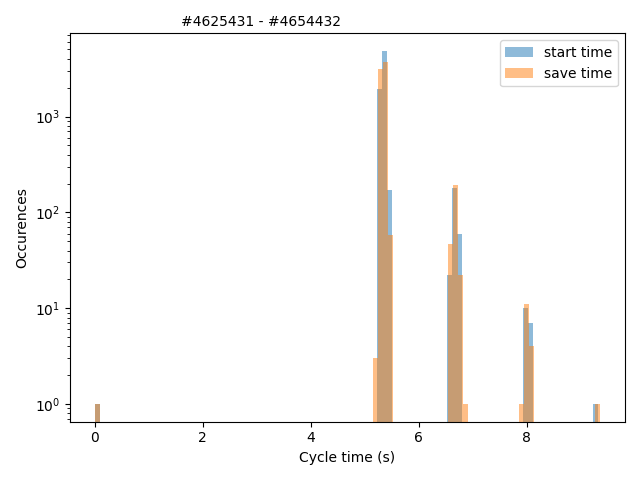

In [95]:
fig, ax = plt.subplots()
cycle_time_end_times = np.concatenate([[0], results[:, col_indices["end_time"]][1:] - results[:, col_indices["end_time"]][:-1]])
ax.text(0.2, 1.02, f'#{first} - #{last}', transform = ax.transAxes)
ax.hist(cycle_times[mask], bins=100, alpha=0.5, label="start time")
ax.hist(cycle_time_end_times[mask], bins=100, alpha=0.5, label="save time")
ax.set_xlabel("Cycle time (s)")
ax.set_ylabel("Occurences")
ax.legend()
ax.set_yscale("log")
plt.tight_layout()
plt.show()

## cycle time simulation

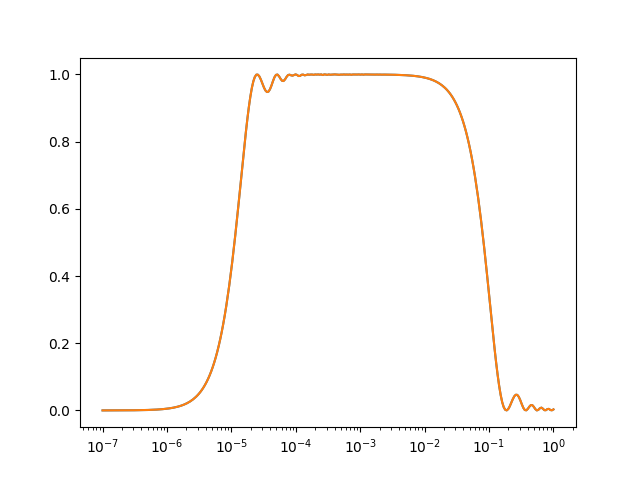

In [30]:
from scipy.interpolate import interp1d
times = results[:, col_indices["start_time"]].astype(float)[mask]

times_test = times
max_powers_test = []
phases = np.linspace(0, 2 * np.pi, 20, endpoint=False)
freqs_test = np.logspace(-7, 0, 300)
times_test_start = times_test - cycle_time_avg / 2
times_test_end = times_test + cycle_time_avg / 2
for freq_test in freqs_test:
    temp = []
    for phase in phases:
        signal_test = (np.cos(2 * np.pi * freq_test * times_test_start + phase) - np.cos(2 * np.pi * freq_test * times_test_end + phase)) * np.sqrt(2) / (2 * np.pi * freq_test * cycle_time_avg)
        ls_test = LombScargle(times_test, signal_test, normalization="psd")
        temp.append(ls_test.power(freq_test) * 2 / len(times_test))
    max_powers_test.append(np.average(temp))
fig, ax = plt.subplots()
cycle_time_factor = interp1d(freqs_test, max_powers_test)
ax.plot(freqs_test, max_powers_test)
ax.plot(freqs_test, cycle_time_factor(freqs_test))
ax.set_xscale("log")
plt.show()

## Other experiments

In [31]:
nedm_beam = [
    [0.00002397770939369404, 9.895882852108817e-13],
    [0.00007540564274522318, 8.54708812559258e-13],
    [0.00022561365673928302, 5.925530975545711e-13],
    [0.0008659643233600654, 9.19679198511712e-13],
    [0.003672009923118255, 1.7782794100389374e-12],
    [0.007752166233340905, 3.699830414406981e-12],
    [0.026933231346713472, 1.2855557319139138e-11],
    [0.20763840890834542, 1.0000000000000082e-10],
    [4.124626382901348, 1.618418779184068e-9],
    [11.170610862750628, 8.111308307896923e-9],
    [23.58284267992098, 3.511191734215156e-8],
    [47.36753331379177, 2.192345972483451e-7],
    [90.51712870300146, 5.682578639969637e-7],
    [245.14502097605498, 0.000004108056080177289],
    [631.656208626513, 0.00006178870468273718],
    [810.3149399361805, 0.0001031897032767774],
]
nedm = [
    [2.8107285020807224e-10, 1.2382883361478699e-21],
    [1.9120359913544285e-9, 1.4818084916054758e-21],
    [0.000001417668870576385, 1.008585850870895e-18],
    [0.001786358019245735, 7.737735166663486e-16],
    [0.0034310975906798893, 5.251665178243852e-15],
]
hff = [
    [2.3983980358520008e-8, 2.272142910168394e-15],
    [0.259051330252812, 1.9760233819175173e-8],
]
rb_quartz = [
    [0.001303621502071577, 6.654711796333948e-11],
    [0.003661308835364036, 1e-10],
    [0.012855557319139031, 2.1209508879201926e-10],
    [0.055648638769833, 7.196856730011529e-10],
    [0.21544346900318867, 1.9611779729377575e-9],
    [0.7670938216429439, 8.28642772854686e-9],
    [1.6526535398566913, 1.3257113655901082e-8],
    [3.8714957592094787, 2.9012492020268506e-8],
    [8.697490026177835, 4.359691735448471e-8],
    [19.81388768974338, 8.961505019466032e-8],
    [49.77023564332104, 1.7852567354823374e-7],
    [100, 4.864910219855273e-7],
]
exp_bounds = {
    "ultracold neutron": nedm,
    #"HfF$^+$": hff,
    "neutron beam": nedm_beam,
    #"Rb/quartz": rb_quartz,
}

## analysis 08-12

In [32]:
W_T = unumpy.nominal_values(results[:, col_indices["W_T"]])[mask]
#W_T += np.sin(0.48 * 2 * np.pi * times) * 0.063

ls = LombScargle(times, W_T, normalization="psd")

min_freq = 0.5 / duration  # 4 times longer than the oscillation
max_freq = 0.5 / cycle_time_avg
fs, f_W_T_psd = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
f_W_T_psd *= 2 / len(times)

In [33]:
print(min_freq, max_freq, len(fs), fs[1]-fs[0])
print((max_freq - min_freq) / 100)

1.2637635203891125e-05 0.0929496245336575 18386 5.055054081556448e-06
0.0009293698689845361


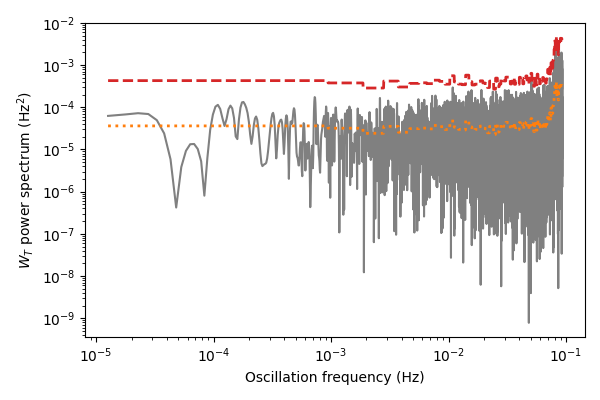

In [34]:
fs_bins = np.linspace(np.min(fs) - 1e-10, np.max(fs) + 1e-10, 100 + 1)
W_T_binned_indices = np.digitize(fs, fs_bins)
W_T_binned = []
for kk in range(1, len(fs_bins)):
    f_W_T_psd_same_bin = f_W_T_psd[W_T_binned_indices==kk]
    W_T_binned.extend([np.average(f_W_T_psd_same_bin)] * len(f_W_T_psd_same_bin))
W_T_binned = np.array(W_T_binned)
W_T_avg_all = np.average(f_W_T_psd)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fs, f_W_T_psd, label="data", color="gray")
ax.plot(fs, W_T_binned, label="binned average", color="C1", ls="dotted", linewidth=2)
global_95_bound = -np.log(1 - 0.95 ** (1/len(times))) * W_T_binned
ax.plot(fs, global_95_bound, label=f"95% confidence level", color="C3", linewidth=2, ls="dashed")
ax.set_ylabel("$W_T$ power spectrum (Hz$^2$)")
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_xscale("log")
ax.set_yscale("log")
#ax.legend()
plt.tight_layout()
plt.savefig("spectrum.pdf")
plt.show()

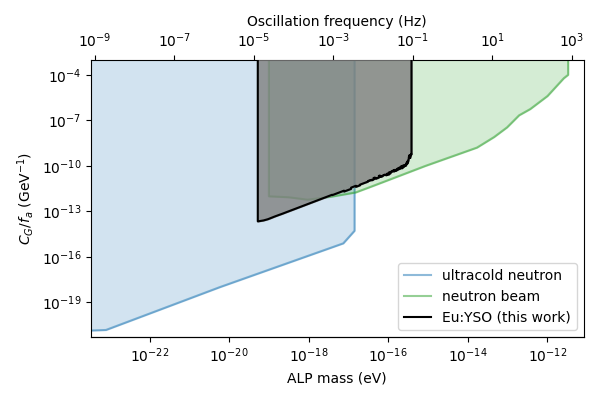

In [36]:
W_T_to_theta = 1 / 110e3
stochastic_factor = 3
inverse_fa_limits = inverse_fa_limit(fs, np.sqrt(global_95_bound * 2 / cycle_time_factor(fs)) * W_T_to_theta) * stochastic_factor

fig, ax = plt.subplots(figsize=(6, 4))
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax1 = ax.secondary_xaxis("bottom", functions=(axion_frequency_to_mass, axion_mass_to_frequency))
counter = 0
for kk in exp_bounds:
    temp_x = np.transpose(exp_bounds[kk])[0]
    temp_y = np.transpose(exp_bounds[kk])[1]
    temp_x = np.append([temp_x[0]], temp_x)
    temp_y = np.append([1], temp_y)
    temp_x = np.append(temp_x, [temp_x[-1]])
    temp_y = np.append(temp_y, [1])
    ax.plot(temp_x, temp_y, label=kk, alpha=0.5, zorder=counter, color=f"C{counter}")
    ax.fill_between(np.transpose(exp_bounds[kk])[0], np.transpose(exp_bounds[kk])[1], 1, alpha=0.2, zorder=counter, color=f"C{counter}")
    counter += 1
    if counter == 1:
        counter += 1
ax.fill_between(fs, inverse_fa_limits, 1, zorder=counter, color="gray", alpha=0.8)
ax.plot(np.append(np.append(fs[0], fs), fs[-1]), np.append(np.append(1, inverse_fa_limits), 1), color="k", label="Eu:YSO (this work)", zorder=counter, alpha=1)
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_ylabel("$C_G / f_a$ (GeV${}^{-1}$)")
ax1.set_xscale("log")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(0.5e-21, 1e-3)
ax.set_xlim(8e-10, 2e3)
ax.set_xticks([1e-9, 1e-7, 1e-5, 1e-3, 0.1, 10, 1e3])
ax1.set_xlabel("ALP mass (eV)")
ax.legend()
plt.tight_layout()
plt.savefig("exclusion.pdf")
plt.show()

## W_T periodgram and binned limit - log bins

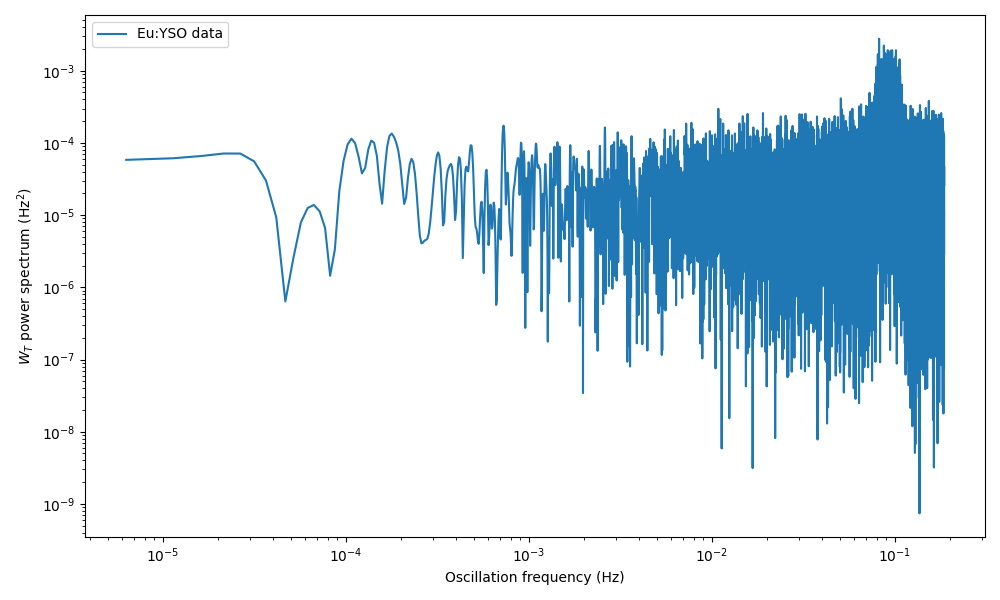

In [37]:
times = results[:, col_indices["start_time"]].astype(float)[mask]
W_T = unumpy.nominal_values(results[:, col_indices["W_T"]])[mask]
# W_T += np.sin(1e-4 * 2 * np.pi * times) * 0.2

W_T_uncs = np.std(W_T) * np.ones(len(W_T))  # assuming error bar is std of the data for every point
ls = LombScargle(times, W_T, normalization="psd")

min_freq = 0.25 / duration  # 4 times longer than the oscillation
max_freq = 1 / cycle_time_avg
fs, f_W_T_psd = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
f_W_T_psd *= 2 / len(times)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fs, f_W_T_psd, label="Eu:YSO data")
ax.set_ylabel("$W_T$ power spectrum (Hz$^2$)")
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
plt.show()

In [38]:
default_fs_bins = np.concatenate(
    [np.logspace(np.log10(np.min(fs)), np.log10(np.max(fs)), 100, endpoint=False), [np.max(fs) + 1e-10]]
)

W_T_binned_indices = np.digitize(fs, default_fs_bins)
fs_bin_start = []
fs_bin_end = []
W_T_binned = []

last_bin_closed = True
for kk in range(1, len(default_fs_bins)):
    if last_bin_closed:
        fs_bin_start.append(default_fs_bins[kk-1])
        W_T_binned.append([])
    W_T_binned[-1].extend(f_W_T_psd[W_T_binned_indices==kk])
    if len(W_T_binned[-1]) > 10:
        last_bin_closed = True
    else:
        last_bin_closed = False
    if last_bin_closed:
        fs_bin_end.append(default_fs_bins[kk])
fs_bin_start = np.array(fs_bin_start)
fs_bin_end = np.array(fs_bin_end)
fs_bin_center = (fs_bin_start + fs_bin_end) / 2
W_T_binned_avg = np.array([np.average(kk) for kk in W_T_binned])
W_T_binned_std = np.array([np.std(kk) for kk in W_T_binned])
W_T_binned_num = np.array([len(kk) for kk in W_T_binned])

In [39]:
len(fs_bin_end / fs_bin_start)

65

0.0018744969517545981
0.6749589892531885


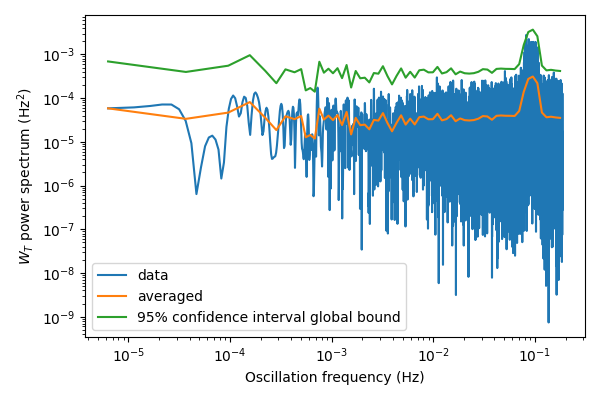

In [40]:

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fs, f_W_T_psd, label="data")
fs_bin_center = np.concatenate([[np.min(fs)], fs_bin_center])
W_T_binned_avg = np.concatenate([[f_W_T_psd[0]], W_T_binned_avg])
ax.plot(fs_bin_center, W_T_binned_avg, label="averaged")
# Z = 1.645  # single sided 95% std
# upper_limits_gaussian = W_T_binned_avg + W_T_binned_std * Z * np.sqrt(W_T_binned_num)
# ax.plot(fs_bin_end, upper_limits_gaussian, label="95% upper limit from the binned data - gaussian")
# upper_limits_exponential = -np.log(1 - 0.95 ** (1/W_T_binned_num)) * W_T_binned_avg  # exponential CDF = 1 - exp(-lambda x), mean = 1 / lambda.
#ax.plot(fs_bin_end, upper_limits_exponential, label="95% upper limit from the binned data - exponential")
upper_limits_exponential_global = -np.log(1 - (1 - 0.5733e-6 / 2) ** (1/len(times))) * np.average(f_W_T_psd)  # this may be wrong due to different data points are correlated. See Eq. 10 of the nEDM paper and text below.
print(upper_limits_exponential_global)
#ax.hlines([upper_limits_exponential_global], np.min(fs), np.max(fs), color="C7", label="95% confidence interval global bound")
print(upper_limits_exponential_global / np.max(f_W_T_psd))

upper_limits_exponential_global_using_local_amplitude = -np.log(1 - 0.95 ** (1/len(times))) * W_T_binned_avg
upper_limits_exponential_global_merged = np.array(upper_limits_exponential_global_using_local_amplitude)
upper_limits_exponential_global_merged[(upper_limits_exponential_global_merged < upper_limits_exponential_global)] = upper_limits_exponential_global
upper_limits_exponential_global_merged[(fs_bin_center < 1e-2)] = upper_limits_exponential_global
# fs_for_upper_limits_merged = np.concatenate([[np.min(fs)], fs_bin_center])
# upper_limits_exponential_global_merged = np.concatenate([[upper_limits_exponential_global], upper_limits_exponential_global_merged])
ax.plot(fs_bin_center, upper_limits_exponential_global_using_local_amplitude, label="95% confidence interval global bound")
ax.set_ylabel("$W_T$ power spectrum (Hz$^2$)")
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
#plt.savefig("spectrum.pdf")
plt.show()

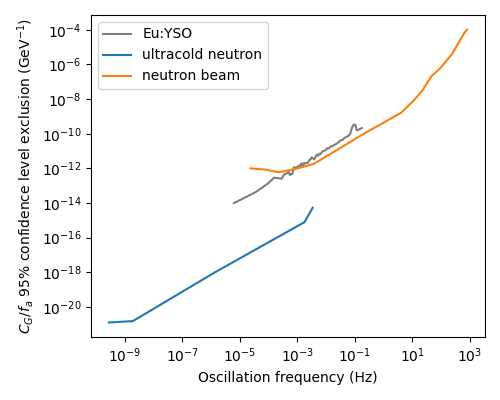

In [41]:
W_T_to_theta = 2.5e-5
inverse_fa_limits = inverse_fa_limit(fs_bin_center, np.sqrt(upper_limits_exponential_global_using_local_amplitude * 2) * W_T_to_theta)

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(fs_bin_center, inverse_fa_limits, color="C7", label="Eu:YSO")
for kk in exp_bounds:
    ax.plot(np.transpose(exp_bounds[kk])[0], np.transpose(exp_bounds[kk])[1], label=kk)
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_ylabel(f"$C_G / f_a$ 95% confidence level" + " exclusion (GeV$^{-1}$)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
plt.savefig("exclusion.pdf")
plt.show()

## Extend to ~1.7 Hz

In [284]:
times = results[:, col_indices["start_time"]].astype(float)[mask]
W_T = unumpy.nominal_values(results[:, col_indices["W_T"]])[mask]
#W_T += np.sin(0.48 * 2 * np.pi * times) * 0.063

ls = LombScargle(times - times[0], W_T, normalization="psd")

min_freq = 4.0#0.5 / duration  # 2 times longer than the oscillation
max_freq = 4.4#8 / cycle_time_avg
fs, f_W_T_psd = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=7)
f_W_T_psd *= 2 * sample_time

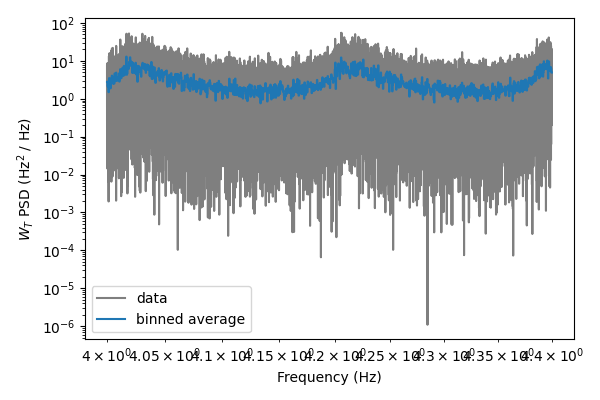

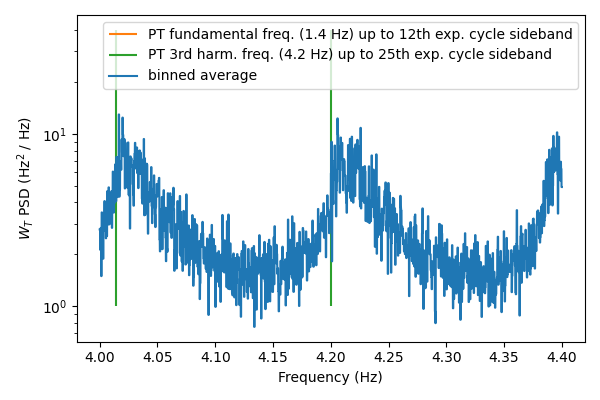

In [288]:
fs_bins = np.linspace(np.min(fs) - 1e-10, np.max(fs) + 1e-10, 1000 + 1)
W_T_binned_indices = np.digitize(fs, fs_bins)
W_T_binned = []
for kk in range(1, len(fs_bins)):
    f_W_T_psd_same_bin = f_W_T_psd[W_T_binned_indices==kk]
    W_T_binned.extend([np.average(f_W_T_psd_same_bin)] * len(f_W_T_psd_same_bin))
W_T_binned = np.array(W_T_binned)
W_T_avg_all = np.average(f_W_T_psd)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fs, f_W_T_psd, label="data", color="C7")
ax.plot(fs, W_T_binned, label="binned average")
global_95_bound = -np.log(1 - 0.95 ** (1/len(times))) * W_T_binned
#ax.plot(fs, global_95_bound, label=f"95% confidence level", color="gray")
ax.set_ylabel("$W_T$ PSD (Hz$^2$ / Hz)")
ax.set_xlabel("Frequency (Hz)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
plt.show()


pt_freqs = []
for kk in range(0, 20):
    for ll in [1]:
        freq = abs(kk * cycle_frequency_avg - 1.4 * ll)
        if freq < 1.6:
            pt_freqs.append(freq)
fig, ax = plt.subplots(figsize=(6, 4))

pt_freqs = []
for kk in range(0, 13):
    for ll in [1]:
        freq = abs(kk * cycle_frequency_avg - 1.4 * ll)
        if freq < 4.4 and freq > 4.0:
            pt_freqs.append(freq)
ax.vlines(pt_freqs, 1., 40, color="C1", label="PT fundamental freq. (1.4 Hz) up to 12th exp. cycle sideband")
pt_freqs = []
for kk in range(0, 26):
    for ll in [3]:
        freq = abs(kk * cycle_frequency_avg - 1.4 * ll)
        if freq < 4.4 and freq > 4.0:
            pt_freqs.append(freq)
ax.vlines(pt_freqs, 1., 40, color="C2", label="PT 3rd harm. freq. (4.2 Hz) up to 25th exp. cycle sideband")
ax.plot(fs, W_T_binned, label="binned average")
ax.set_ylabel("$W_T$ PSD (Hz$^2$ / Hz)")
ax.set_xlabel("Frequency (Hz)")
ax.set_yscale("log")
ax.legend()
#ax.set_xlim(0.05, 1.5)
plt.tight_layout()
plt.show()

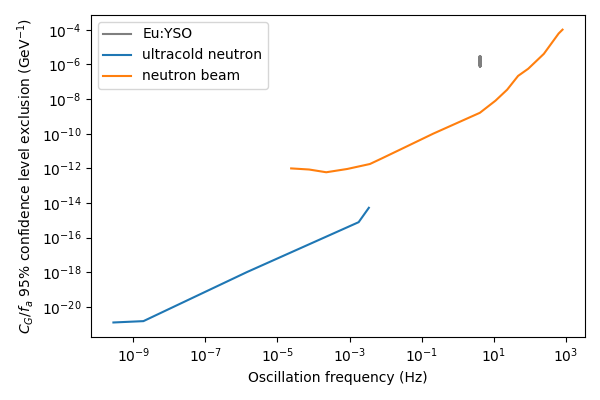

In [286]:
W_T_to_theta = 2.5e-5
inverse_fa_limits = inverse_fa_limit(fs, np.sqrt(global_95_bound * 2) * W_T_to_theta)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fs, inverse_fa_limits, color="C7", label="Eu:YSO")
for kk in exp_bounds:
    ax.plot(np.transpose(exp_bounds[kk])[0], np.transpose(exp_bounds[kk])[1], label=kk)
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_ylabel(f"$C_G / f_a$ 95% confidence level" + " exclusion (GeV$^{-1}$)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
plt.savefig("exclusion.pdf")
plt.show()

## power aliasing

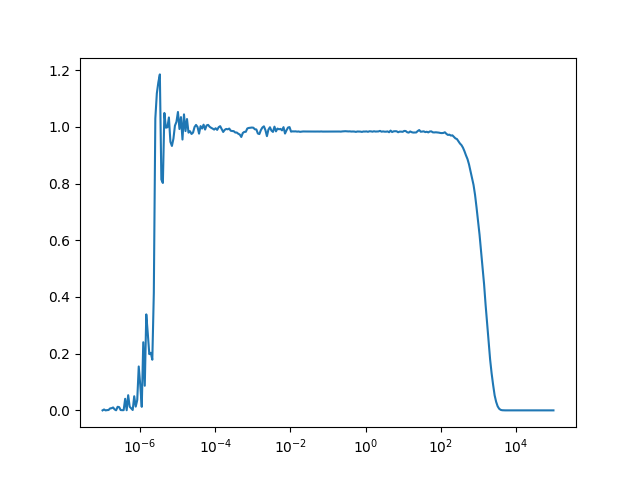

In [40]:
times_test = times
max_powers_test = []
freqs_test = np.logspace(-7, 5, 300)
for freq_test in freqs_test:
    signal_test = np.sin(2 * np.pi * freq_test * (times_test + 1e-4 * np.random.normal(size=len(times_test)))) * np.sqrt(2)
    ls_test = LombScargle(times_test, signal_test, normalization="psd")
    #max_powers_test.append(ls_test.power(freq_test) * 2 / len(times_test))
    if freq_test < 1e-2:
        max_powers_test.append(np.max(ls_test.autopower(minimum_frequency=freq_test * (1-1e-3), maximum_frequency=freq_test*(1+1e-3))[1]) * 2 / len(times_test))
    else:
        max_powers_test.append(np.max(ls_test.autopower(minimum_frequency=freq_test -1.1e-3, maximum_frequency=freq_test+1e-3)[1]) * 2 / len(times_test))
fig, ax = plt.subplots()
ax.plot(freqs_test, max_powers_test)
ax.set_xscale("log")
plt.show()

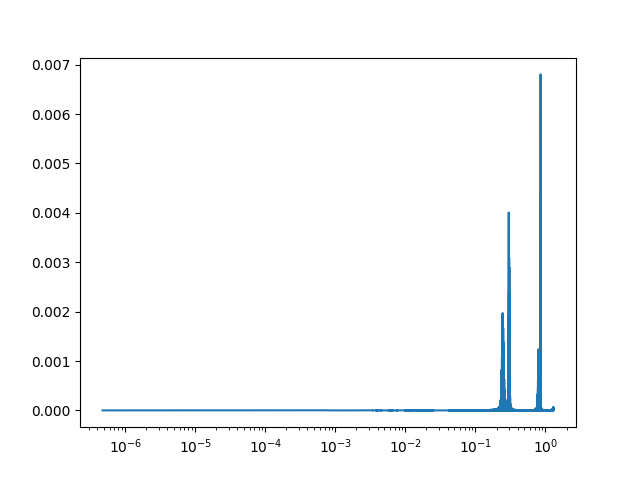

In [41]:
times_test = times
freq_test = 1.4
signal_test = np.sin(2 * np.pi * freq_test * (times_test + 1e-4* np.random.normal(size=len(times_test)))) * np.sqrt(2)
ls_test = LombScargle(times_test, signal_test, normalization="psd")
freq_tests, max_powers_test = ls_test.autopower()
max_powers_test *= 2 / len(times_test)
fig, ax = plt.subplots()
ax.plot(freq_tests, max_powers_test)
ax.set_xscale("log")
plt.show()

## Exponential distribution confirmation

7.855527131345174e-05


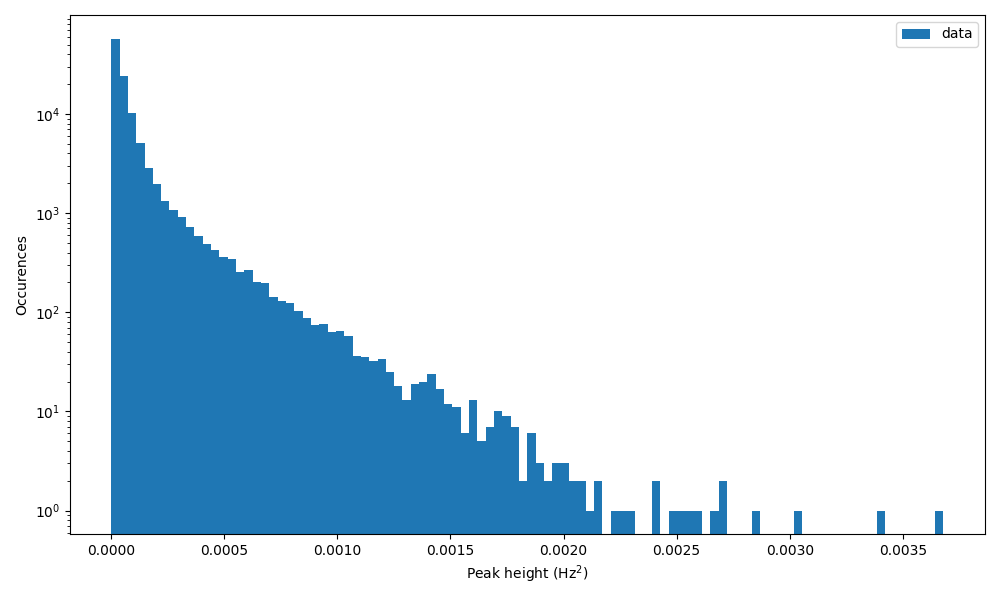

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(f_W_T_psd, label="data", bins=100)
# filter = np.zeros(len(f_W_T_psd), dtype=bool)
# filter = ((fs < 1.40004) | (fs > 1.4003)) & ((fs < 2.534) | (fs > 2.566))
# ax.hist(f_W_T_psd[filter], label="data", bins=100)
print(np.average(f_W_T_psd))
#ax.plot([0, 0.00132], [1.8e6, 1e-2])
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("Peak height (Hz$^2$)")
ax.set_ylabel("Occurences")
plt.tight_layout()
plt.show()

C:\Users\mingy\AppData\Local\Temp\ipykernel_12244\2380455247.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


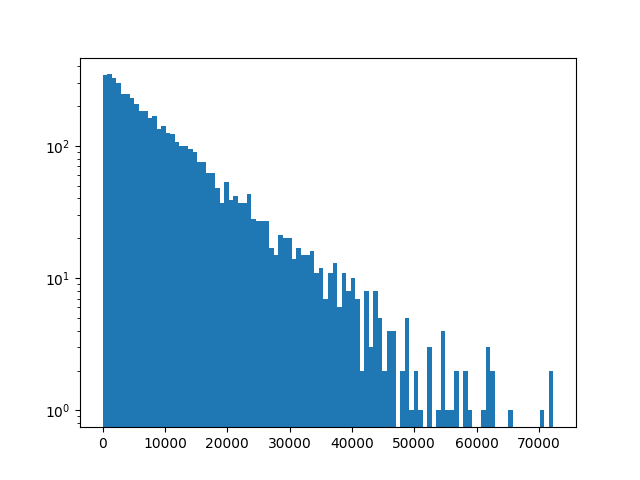

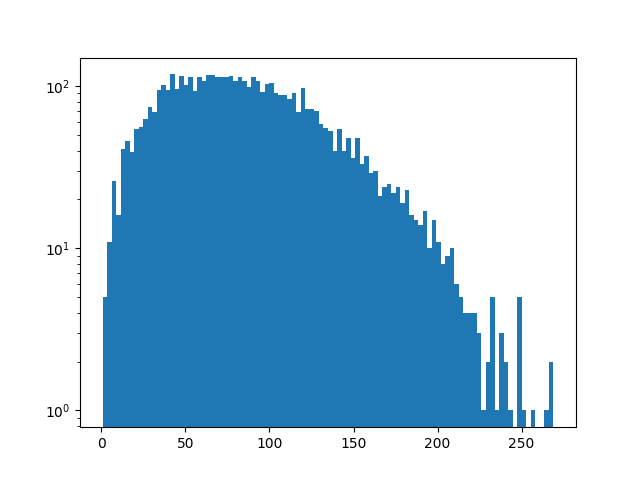

In [43]:
test_t_data = np.random.normal(size=10000)
test_ts = np.arange(len(test_t_data))
test_f_data = np.fft.rfft(test_t_data)
fig, ax = plt.subplots()
ax.hist(np.abs(test_f_data)**2, bins=100)
ax.set_yscale("log")
plt.show()
fig, ax = plt.subplots()
ax.hist(np.abs(test_f_data), bins=100)
ax.set_yscale("log")
plt.show()

## astropy 95%

0.22372892144829667
0.20540118657579093
0.22406126571548085


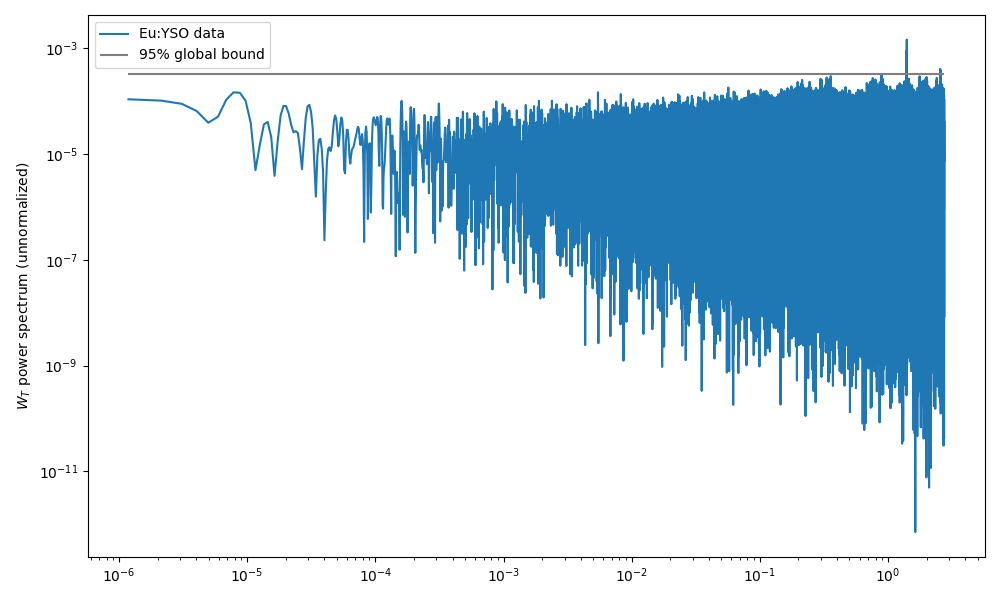

In [44]:
ls1 = LombScargle(times, W_T)

min_freq = 0.25 / duration  # 4 times longer than the oscillation
max_freq = 5 / cycle_time_avg
fs1, f_W_T_psd1 = ls1.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)

f_W_T_psd1_fal = ls1.false_alarm_level(0.05, minimum_frequency=min_freq, maximum_frequency=max_freq)
print(ls1.false_alarm_level(0.05, minimum_frequency=min_freq, maximum_frequency=max_freq, method="baluev") / np.max(f_W_T_psd1))
print(ls1.false_alarm_level(0.05, minimum_frequency=min_freq, maximum_frequency=max_freq, method="naive") / np.max(f_W_T_psd1))
print(ls1.false_alarm_level(0.05, minimum_frequency=min_freq, maximum_frequency=max_freq, method="davies") / np.max(f_W_T_psd1))
# print(ls1.false_alarm_level(0.05, minimum_frequency=min_freq, maximum_frequency=max_freq, method="bootstrap") / np.max(f_W_T_psd1))  # takes forever
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fs1, f_W_T_psd1, label="Eu:YSO data")
ax.hlines([f_W_T_psd1_fal], np.min(fs1), np.max(fs1), label="95% global bound", color="C7")
ax.set_ylabel("$W_T$ power spectrum (unnormalized)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
plt.show()